
# Factor-Based Covariance Matrix Estimation

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data Handling

In [2]:
daily_PFr = pd.read_csv('100_Portfolios_10x10_Daily-VW.csv', skiprows = 1, header = 0, index_col = 0)
daily_PFr.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
19260701,-99.99,0.00,-99.99,1.59,-3.08,4.64,2.57,3.81,-0.52,-0.84,...,0.03,1.10,-0.15,-0.03,0.52,0.48,-0.43,-0.08,0.17,-99.99
19260702,-99.99,-0.27,-99.99,0.00,-0.97,-4.10,0.31,-0.47,2.74,-0.27,...,0.31,0.71,0.97,0.57,0.52,0.15,0.63,-0.04,0.34,-99.99
19260706,-99.99,1.01,-99.99,-4.69,2.35,-1.79,0.00,2.44,-5.18,-0.23,...,0.49,-0.19,0.89,0.31,-0.12,-0.18,-0.33,-0.40,-0.34,-99.99
19260707,-99.99,-1.67,-99.99,4.92,0.51,5.27,0.00,-0.74,-0.24,-0.02,...,-0.20,-0.01,0.66,0.38,0.03,0.25,-0.29,0.52,0.17,-99.99
19260708,-99.99,0.00,-99.99,1.56,-0.51,-1.06,0.00,4.90,0.45,0.26,...,0.56,-0.12,0.35,0.55,-0.14,0.19,-0.12,0.54,0.51,-99.99


In [3]:
weekly_factor_all = pd.read_csv('F-F_Research_Data_Factors_weekly.csv', skiprows = 4, header = 0, index_col = 0)

Split the factor dataset into 2 datasets: one contains risk-free rate - assigned to the variable *weekly_RF* and one contains the weekly factor *'Mkt-RF', 'SMB', 'HML'* - assigned to the variable *weekly_factor*

In [4]:
weekly_factor = weekly_factor_all[['Mkt-RF', 'SMB', 'HML']].loc['1970-01-01':]
weekly_RF = weekly_factor_all[['RF']].loc['1970-01-01':]
weekly_factor

,Mkt-RF,SMB,HML
19700102,1.34,1.30,0.60
19700109,-0.58,1.52,0.51
19700116,-1.86,-0.60,-0.69
19700123,-2.03,0.81,1.25
19700130,-4.92,0.02,1.24
...,...,...,...
20230630,2.36,0.58,0.35
20230707,-1.23,-0.42,1.33
20230714,2.53,1.38,-0.76
20230721,0.64,-0.01,2.47


Replace -99.99 by NaN, select data from 02 Jan 1970 to 28 Jul 2023, and drop the columns that contains at least 1 NaN value.

There are 96 portfolios left.

In [5]:
daily_PFr.replace(-99.99, np.nan, inplace=True)
daily_PFr = daily_PFr.loc['19700102':'20230728'].dropna(axis=1, how='any')
daily_PFr.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
19700102,5.34,3.66,4.81,3.37,3.70,4.44,5.11,2.35,3.04,3.15,...,2.41,2.31,3.89,-0.07,1.33,-0.09,0.92,2.12,1.02,0.78
19700105,2.17,2.10,3.24,1.92,2.42,1.49,2.63,2.54,2.55,2.07,...,1.12,1.42,1.60,0.37,-0.03,-0.15,1.06,-0.18,1.03,0.81
19700106,-0.93,-0.96,-0.42,-0.78,-0.28,0.17,-0.13,-0.28,-0.46,0.06,...,-0.99,-1.10,-0.85,-0.39,-0.59,-1.00,-0.89,-0.64,-1.47,-0.78
19700107,1.24,0.53,1.37,0.70,0.67,0.22,1.20,0.34,0.34,0.74,...,0.01,-0.32,-0.29,0.11,-0.18,0.07,-0.83,-0.34,-0.41,-0.48
19700108,0.94,0.91,0.03,1.01,0.21,0.44,0.73,0.20,0.13,0.65,...,-0.15,0.07,-0.17,0.38,0.11,0.02,-0.67,-0.14,-0.28,0.01


Assign normalized value 1 to the variable init_inv as the initial investment value of $1, calculate cummulative product of *(1+daily_PFr/100)* (i.e the gross returns) to calculate value of portfolios everyday in the dataset.

In [6]:
init_inv = 1
daily_PFvalue = (1 + daily_PFr / 100).cumprod() * init_inv
daily_PFvalue.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
19700102,1.053400,1.036600,1.048100,1.033700,1.037000,1.044400,1.051100,1.023500,1.030400,1.031500,...,1.024100,1.023100,1.038900,0.999300,1.013300,0.999100,1.009200,1.021200,1.010200,1.007800
19700105,1.076259,1.058369,1.082058,1.053547,1.062095,1.059962,1.078744,1.049497,1.056675,1.052852,...,1.035570,1.037628,1.055522,1.002997,1.012996,0.997601,1.019898,1.019362,1.020605,1.015963
19700106,1.066250,1.048208,1.077514,1.045329,1.059122,1.061763,1.077342,1.046558,1.051814,1.053484,...,1.025318,1.026214,1.046550,0.999086,1.007019,0.987625,1.010820,1.012838,1.005602,1.008039
19700107,1.079471,1.053764,1.092276,1.052647,1.066218,1.064099,1.090270,1.050117,1.055391,1.061280,...,1.025420,1.022930,1.043515,1.000185,1.005207,0.988317,1.002431,1.009394,1.001479,1.003200
19700108,1.089618,1.063353,1.092603,1.063278,1.068457,1.068781,1.098229,1.052217,1.056763,1.068178,...,1.023882,1.023646,1.041741,1.003985,1.006312,0.988514,0.995714,1.007981,0.998675,1.003300


Reindex the daily value dataframe on a weekly basis to match index of factor dataframe, while filling NaN by the latest available value.

In [7]:
weekly_PFvalue = daily_PFvalue.reindex(weekly_factor.index).ffill()

weekly_PFreturn = weekly_PFvalue.pct_change()
weekly_PFreturn.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
19700102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19700109,0.031796,0.027655,0.035685,0.025220,0.029304,0.020787,0.037837,0.029805,0.024149,0.035661,...,-0.002412,-0.002968,-0.001376,0.005292,-0.007293,-0.016136,-0.018592,-0.017485,-0.031082,-0.005062
19700116,-0.015258,-0.029384,-0.029480,-0.033742,-0.017554,-0.016339,-0.042613,-0.020226,-0.014835,-0.010470,...,-0.026729,-0.030440,-0.022244,-0.002597,-0.016025,-0.003335,-0.013893,-0.026941,-0.032872,-0.021724
19700123,-0.012650,-0.010300,-0.014084,-0.002581,-0.026777,-0.012035,-0.014454,-0.005561,-0.012658,-0.006017,...,-0.005011,0.006010,0.000551,-0.037102,-0.009586,-0.021845,-0.024583,-0.008343,-0.018739,-0.026157
19700130,-0.046885,-0.060140,-0.057800,-0.038608,-0.049756,-0.051404,-0.046433,-0.046143,-0.036619,-0.025736,...,-0.045612,-0.061167,-0.031281,-0.056894,-0.052965,-0.028781,-0.058693,-0.039594,-0.062653,-0.054100


## Calculate factor-based covariance matrix

Now let's create a function taking in two dataframes of assets' returns and FF factors, and returning the factor-based covariance matrix.

In [8]:
def FB_cov_matrix(returns_df = pd.DataFrame, factor = pd.DataFrame):

    X = sm.add_constant(factor)
    T = returns_df.shape[0]
    K = factor.shape[1]
    beta = pd.DataFrame(columns=returns_df.columns)
    residual_sum = []

    for column_name in returns_df.columns:
        
        PFreturns = returns_df[column_name].values
        model = sm.OLS(PFreturns, X).fit()
        #result = model.fit()
        
        beta[column_name] = model.params[1:].to_list()
        PFreturns_pred = model.predict(X)
        
        residual = model.resid.values
        residual_sum.append((residual**2).sum())

    #beta_trans = beta.T
    sigma_F = beta.T.cov()
    #sigma_error = np.identity(len(residual_sum))
    var_residual = 1/(T-K-1) * np.array(residual_sum)
    sigma_error = np.diag(var_residual)
    
    return beta.T@sigma_F@beta + sigma_error


In [9]:
def sample_cov_matrix(returns = pd.DataFrame):
    return returns.cov()

Function for Global mean variance portfolio weight calculation, taking in a covariance matrix and return the weight of the GMV portfolio, using the given formula:
$$
W_{GMV} = \frac{Σ^{-1}\mathbb{1}}{\mathbb{1}'Σ^{-1}\mathbb{1}}
$$

In [10]:
def GMV_weight(cov_matrix = pd.DataFrame):
    ones = np.ones((cov_matrix.shape[0], 1))
    return (np.linalg.inv(cov_matrix)@ones)/((np.linalg.inv(cov_matrix) @ ones).sum())

Calculate covariance matrix using historical returns in the dataframe `weekly_PFreturn_ex`, which contains weekly excess return of the portfolios. Then we use this covariance matrix to calculate the GMV weight. `W_GMV_sc` means we are using sample covariance method, to compare with `W_GMV_FB` later, using factor-based covariance matrix.

In [11]:
# Calculate sample covariance matrix
sample_cov = sample_cov_matrix(weekly_PFreturn.loc['2021-01-01': '2023-01-01'])

# Use sample covariance matrix to calculate GMV weight
W_GMV_sc = GMV_weight(sample_cov)

# Calculate factor-based covariance matrix
FB_cov = FB_cov_matrix(weekly_PFreturn.loc['2021-01-01': '2023-01-01'], weekly_factor.loc['2021-01-01': '2023-01-01'])

# Use factor-based matrix to calculate GMV weight
W_GMV_FB = GMV_weight(FB_cov)

Then we calculate the range of each GMV weight using 2 different covariance matrices (=the highest weight - the lowest weight). We can see that using factor-based covariance matrix produces lower range of weights

In [12]:
print('range of weights using factor-based covariance matrix is', np.max(W_GMV_FB) - np.min(W_GMV_FB))
print('range of weights using sample covariance matrix is', np.max(W_GMV_sc) - np.min(W_GMV_sc))

range of weights using factor-based covariance matrix is 0.03434075990481198
range of weights using sample covariance matrix is 3.573140220158016


## Leverage

This function takes in the weight of portfolio and returns the leverage amount, using given formula

In [13]:
def leverage(weights = np.ndarray):
    return 1/2*((np.sum(np.abs(weights)))-1)

In [14]:
leverage_sc = leverage(W_GMV_sc)
print('Leverage amount of GMV portfolio using sample cov matrix is', leverage_sc)

Leverage amount of GMV portfolio using sample cov matrix is 22.896616192989804


In [15]:
leverage_FB = leverage(W_GMV_FB)
print('Leverage amount of GMV portfolio using sample cov matrix is', leverage_FB)

Leverage amount of GMV portfolio using sample cov matrix is 0.0


## Portfolio weight plotting

In [16]:
weekly_PFreturn_excess = weekly_PFreturn - weekly_RF.loc['19700102':'20230728'].values
weekly_PFreturn_excess.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
19700102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19700109,-0.119204,-0.123345,-0.115315,-0.125780,-0.121696,-0.130213,-0.113163,-0.121195,-0.126851,-0.115339,...,-0.153412,-0.153968,-0.152376,-0.145708,-0.158293,-0.167136,-0.169592,-0.168485,-0.182082,-0.156062
19700116,-0.166258,-0.180384,-0.180480,-0.184742,-0.168554,-0.167339,-0.193613,-0.171226,-0.165835,-0.161470,...,-0.177729,-0.181440,-0.173244,-0.153597,-0.167025,-0.154335,-0.164893,-0.177941,-0.183872,-0.172724
19700123,-0.163650,-0.161300,-0.165084,-0.153581,-0.177777,-0.163035,-0.165454,-0.156561,-0.163658,-0.157017,...,-0.156011,-0.144990,-0.150449,-0.188102,-0.160586,-0.172845,-0.175583,-0.159343,-0.169739,-0.177157
19700130,-0.197885,-0.211140,-0.208800,-0.189608,-0.200756,-0.202404,-0.197433,-0.197143,-0.187619,-0.176736,...,-0.196612,-0.212167,-0.182281,-0.207894,-0.203965,-0.179781,-0.209693,-0.190594,-0.213653,-0.205100


In [17]:
def rolling_windows_make(a: int, b: int, len_win: int, shift: int):
    """
    Return the start and the end indices of rolling windows of length n with a shift of q in the range [a, b].
    """
    k_max = int((b - a + 1 - len_win) / shift)
    start = a + np.arange(0, k_max + 1, dtype=np.int64) * shift
    end = start + len_win
    
    return start, end

def weekly_GMV_simulation_sc(returns = pd.DataFrame, start = np.ndarray, end = np.ndarray):
    '''
    Function to return GMV weight of each window
    '''
    
    #create a blank list to store later value of GMV portfolio weights of each window
    GMV_weight_list = []
    
    #loop through each start week and end week at the same time by using 'for' loop and zip() method
    for i,j in zip(start, end):
        
        #take out the covariance matrix from start week to end week
        sample_cov = sample_cov_matrix(returns.iloc[i:j])
        
        #calculate the GMV weights and add in the 'GMV_weight_list' list
        GMV_weight_sc = GMV_weight(sample_cov).flatten()
        GMV_weight_list.append(GMV_weight_sc)
    
    #convert the 'GMV_weight_list' list to dataframe for easier calculation later
    GMV_weight_df = pd.DataFrame(GMV_weight_list, columns=returns.columns)

    return GMV_weight_df


Using `rolling_windows_make` function to get 2 arrays of start weeks and end weeks

In [18]:
start_week, end_week = rolling_windows_make(0, weekly_PFreturn_excess.shape[0], 156, 12)

Using `weekly_GMV_simulation_sc` function above to simulate GMV weights of each window, calculation is based on data from `weekly_PFreturn_excess` containing excess return of portfolios.

In [19]:
GMV_simulation_sc = weekly_GMV_simulation_sc(weekly_PFreturn_excess, start_week, end_week)

Plot the simulation using `matplotlib` library, with x-axis is the n-th week in the time range of `weekly_PFreturn_excess`, and y-axis shows the weight of portfolios of each week respectively

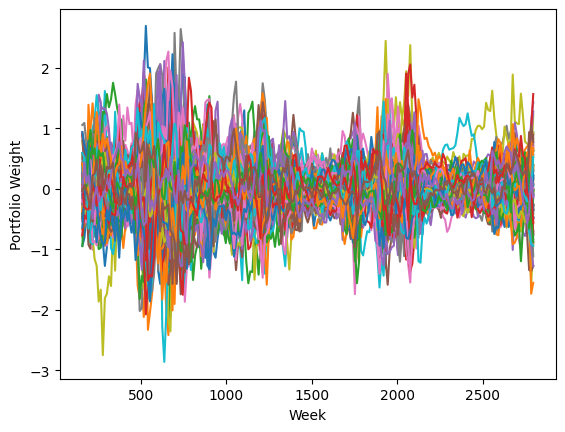

In [20]:
plt.plot(end_week, GMV_simulation_sc)
plt.xlabel("Week")
plt.ylabel("Portfolio Weight")
plt.show()

New function with same idea as the function `weekly_GMV_simulation_sc` but we need a factor dataframe now to calculate the factor-based covariance matrix.

In [21]:
def weekly_GMV_simulation_FB(returns = pd.DataFrame, factor = pd.DataFrame,start = np.ndarray, end = np.ndarray):

    GMV_weight_list = []
    
    for i,j in zip(start, end):
        FB_cov = FB_cov_matrix(returns.iloc[i:j], factor.iloc[i:j])
        GMV_weight_sc = GMV_weight(FB_cov).flatten()
        GMV_weight_list.append(GMV_weight_sc)

    GMV_weight_df = pd.DataFrame(GMV_weight_list, columns=returns.columns)

    return GMV_weight_df

Make a new dataframe for weekly factor values from 02 Jan 1970 to 28 Jul 2023, as an input for the `weekly_GMV_simulation_FB` function

In [22]:
wk_factor = weekly_factor.loc['19700102':'20230728']
wk_factor

,Mkt-RF,SMB,HML
19700102,1.34,1.30,0.60
19700109,-0.58,1.52,0.51
19700116,-1.86,-0.60,-0.69
19700123,-2.03,0.81,1.25
19700130,-4.92,0.02,1.24
...,...,...,...
20230630,2.36,0.58,0.35
20230707,-1.23,-0.42,1.33
20230714,2.53,1.38,-0.76
20230721,0.64,-0.01,2.47


Simulate the GMV weight through windows, but now using the factor-based covariance matrix:

In [23]:
GMV_simulation_FB = weekly_GMV_simulation_FB(weekly_PFreturn_excess, wk_factor, start_week, end_week)

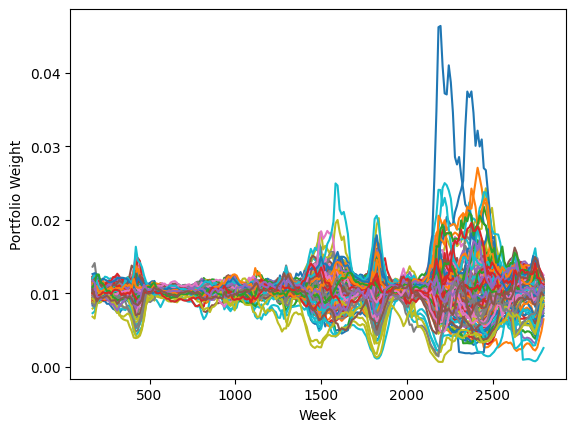

In [24]:
plt.plot(end_week,GMV_simulation_FB)
plt.xlabel("Week")
plt.ylabel("Portfolio Weight")
plt.show()

The portfolio weights using factor-based covariance matrix have much less deviation compared to that of portfolios using sample covariance.